In [2]:
import pandas as pd
import numpy as np

### 1. Sample description

#### The target variable is d(basis) which denotes the daily change of basis. The corresponding features of d(basis) at time t are data at time t-1.

In [3]:
#import data
df = pd.read_excel('c:/Users/cjyjy/Desktop/basis.xlsx',sheetname='daily data',sep='')
df.head()

,Date,d(basis),d(basis)-1,$index,VIX,TED,LIBOROIS,solvency risk
0,2017-04-10,-2.2500,-0.6250,1230.31,12.87,34.23851,20.89,-0.11
1,2017-04-07,-0.6250,-0.0625,1226.58,12.39,35.02900,20.57,-0.11
2,2017-04-06,-0.0625,0.8125,1224.35,12.89,35.03588,20.82,-0.10
3,2017-04-05,0.8125,0.5000,1225.70,11.79,37.52300,21.08,-0.09
4,2017-04-04,0.5000,-0.1250,1223.58,12.38,39.05925,21.67,-0.08


#### we can see form the graph below that the changes of 2yr EURUSD basis was very small before 2007, extrmely large at 2008-2009(global financial crisis)  and 2010-2012(European sovereign debt crisis) and have remain volatile since then.

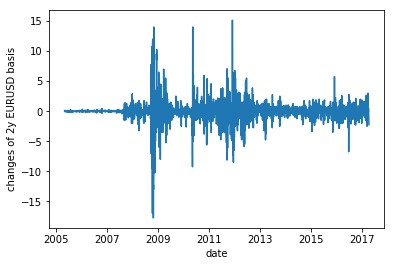

In [4]:
#plot the weekly changes of 2yr EURUSD basis from May 2005 to March 2017
import matplotlib.pyplot as plt

plt.plot(df.iloc[:,0].values,df.iloc[:,1].values)
plt.xlabel('date')
plt.ylabel('changes of 2y EURUSD basis')
plt.show()

In [5]:
#data description
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
d(basis),2974.0,-0.008460,1.646596,-17.75000,-0.300000,0.00000,0.3750,15.12500
d(basis)-1,2974.0,-0.007704,1.646082,-17.75000,-0.300000,0.00000,0.3750,15.12500
$index,2974.0,1048.006688,88.142273,905.27000,987.675000,1022.24500,1081.9575,1277.53000
VIX,2974.0,19.411247,9.427666,9.89000,13.290000,16.48000,22.4200,80.86000
TED,2974.0,47.524557,48.824537,9.55487,22.322495,32.15338,46.8264,463.10999
LIBOROIS,2974.0,29.624667,37.375382,1.91000,11.660000,15.52500,32.7350,364.42000
solvency risk,2974.0,0.426856,0.818642,-0.77000,-0.110000,0.27000,0.7300,3.67000


## 2.Predicting labeled target variables

In [6]:
#encode the lable. when basis goes up(down), y=1(0)
from sklearn.preprocessing import LabelEncoder

y=(df.iloc[:,1].values>0)
le = LabelEncoder()
y = le.fit_transform(y)
le.transform([True, False])
X = df.iloc[:,2:].values

In [7]:
#split data set 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Try random forest, KNN, logistic regression and support vector machine respctively. 
### Firstly, find best parameters via GridSearch. Secondly, plot the learning curves and validation curves of random forest, KNN, logistic regression, support vector machine, AdaBoost and Bagging using the parameters in the first step, and evaluate their performance. 

#### The accuricies are all between 0.5 and 0.6. 

In [8]:
#tuning the parameters via gridsearch

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

forest = RandomForestClassifier(criterion='entropy',random_state=0)
knn = KNeighborsClassifier(p=2, metric='minkowski')
lr=LogisticRegression(random_state=0)
svm = SVC(random_state=0)


forest_param_range = np.arange(5,30)
forest_param_grid = [{'clf__n_estimators': forest_param_range}]

knn_param_range = np.arange(3,15)
knn_param_grid = [{'clf__n_neighbors': knn_param_range}]

lr_param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
lr_param_grid = [{'clf__C': lr_param_range}]

svm_param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
svm_param_grid = [{'clf__C': svm_param_range, 
               'clf__kernel': ['linear']},
                 {'clf__C': svm_param_range, 
                  'clf__gamma': svm_param_range, 
                  'clf__kernel': ['rbf']}]
for clf,clfname,param_grid in zip([forest, knn, lr, svm],['forest','knn','logistic regression','svm'], 
                                  [forest_param_grid, knn_param_grid,lr_param_grid,svm_param_grid]):
    if clf != forest:
        pipe = Pipeline([('scl', StandardScaler()), ('clf', clf)])
        pipe_pca = Pipeline([('scl', StandardScaler()), ('pca', PCA(n_components=2)),('clf', clf)])
    else:
        pipe = Pipeline([('clf', clf)])
        pipe_pca = Pipeline([('pca', PCA(n_components=2)),('clf', clf)])
        
    gs = GridSearchCV(estimator=pipe, 
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=10)
    gs_pca = GridSearchCV(estimator=pipe_pca, 
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=10)
    gs = gs.fit(X_train, y_train)
    gs_pca = gs_pca.fit(X_train, y_train)
    print('%s(without pca/with pca):\n      best score:%.3f/%.3f;\n      test accuracy:%.3f/%.3f;\n      best params:%r/%r'
          %(clfname, gs.best_score_, gs_pca.best_score_, gs.score(X_test, y_test),
            gs_pca.score(X_test, y_test), gs.best_params_, gs_pca.best_params_))


C:\Users\cjyjy\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


forest(without pca/with pca):
      best score:0.573/0.562;
      test accuracy:0.587/0.561;
      best params:{'clf__n_estimators': 16}/{'clf__n_estimators': 6}
knn(without pca/with pca):
      best score:0.605/0.578;
      test accuracy:0.566/0.585;
      best params:{'clf__n_neighbors': 4}/{'clf__n_neighbors': 14}
logistic regression(without pca/with pca):
      best score:0.600/0.594;
      test accuracy:0.592/0.570;
      best params:{'clf__C': 0.1}/{'clf__C': 0.1}
svm(without pca/with pca):
      best score:0.607/0.599;
      test accuracy:0.608/0.578;
      best params:{'clf__C': 100.0, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}/{'clf__C': 1.0, 'clf__gamma': 1.0, 'clf__kernel': 'rbf'}


### cross-validation accuracy
#### The standard deviations of CV accuracies are much smaller than those in weekly data.

In [9]:
# use the parameters above.

forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=16, 
                                random_state=1)
knn = KNeighborsClassifier(n_neighbors=4, p=2, metric='minkowski')
lr=LogisticRegression(C=0.1, random_state=1)
svm = SVC(kernel='rbf', random_state=1, gamma=0.1, C=100.0)

scores=[]

for clf,clfname in zip([forest, knn, lr, svm],['forest','knn','logistic regression','svm']):
    if clf != forest:
        pipe = Pipeline([('scl', StandardScaler()), ('clf', clf)])
    else:
        pipe = Pipeline([('clf', clf)])
        
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, n_jobs=1)
    print('CV Accuracy（%s）: %.3f+/-%.3f' % (clfname,np.mean(scores), np.std(scores)))

CV Accuracy（forest）: 0.570+/-0.026
CV Accuracy（knn）: 0.576+/-0.020
CV Accuracy（logistic regression）: 0.601+/-0.017
CV Accuracy（svm）: 0.548+/-0.020


#### in bagging classifier and AdaBoost classifier, test accuracies are still between 0.5 and 0.6. bagging classifiers and AdaBoost using random forest are overfitting.

In [15]:
#try bagging and adaboost classifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier

for clf,clfname in zip([forest, knn, lr, svm],['forest','knn','logistic regression','svm']):
    bag = BaggingClassifier(base_estimator=clf,
                            n_estimators=500, 
                            max_samples=1.0, 
                            max_features=1.0, 
                            bootstrap=True, 
                            bootstrap_features=False, 
                            n_jobs=1, 
                            random_state=1)
    ada = AdaBoostClassifier(base_estimator=clf,
                             n_estimators=500, 
                             learning_rate=0.1,
                             random_state=1)

    
    if clf == forest :
        
        bag = Pipeline([('clf', bag)])
        bag = bag.fit(X_train, y_train)
        y_train_pred1 = bag.predict(X_train)
        y_test_pred1 = bag.predict(X_test)

        bag_train = accuracy_score(y_train, y_train_pred1) 
        bag_test = accuracy_score(y_test, y_test_pred1) 
    
        ada = Pipeline([('clf', ada)])
        ada = ada.fit(X_train, y_train)
        y_train_pred2 = ada.predict(X_train)
        y_test_pred2 = ada.predict(X_test)

        ada_train = accuracy_score(y_train, y_train_pred2) 
        ada_test = accuracy_score(y_test, y_test_pred2) 

        print('[%s]\n Bagging train/test accuracies %.3f/%.3f  \n AdaBoost train/test accuracies %.3f/%.3f'
              % (clfname,bag_train, bag_test, ada_train, ada_test))
    elif clf == lr:
        bag = Pipeline([('scl', StandardScaler()),('clf', bag)])
        bag = bag.fit(X_train, y_train)
        y_train_pred1 = bag.predict(X_train)
        y_test_pred1 = bag.predict(X_test)
        
        bag_train = accuracy_score(y_train, y_train_pred1) 
        bag_test = accuracy_score(y_test, y_test_pred1) 
    
        ada = Pipeline([('scl', StandardScaler()),('clf', ada)])
        ada = ada.fit(X_train, y_train)
        y_train_pred2 = ada.predict(X_train)
        y_test_pred2 = ada.predict(X_test)

        ada_train = accuracy_score(y_train, y_train_pred2) 
        ada_test = accuracy_score(y_test, y_test_pred2) 
        scores_bag = cross_val_score(estimator=bag, X=X_train, y=y_train, cv=10, n_jobs=1)
        scores_ada = cross_val_score(estimator=ada, X=X_train, y=y_train, cv=10, n_jobs=1)

        print('[%s]\n Bagging train/test accuracies %.3f/%.3f  \n AdaBoost train/test accuracies %.3f/%.3f'
              % (clfname,bag_train, bag_test, ada_train, ada_test))
    else:
        bag = Pipeline([('scl', StandardScaler()), ('clf', bag)])
        bag = bag.fit(X_train, y_train)
        y_train_pred1 = bag.predict(X_train)
        y_test_pred1 = bag.predict(X_test)

        bag_train = accuracy_score(y_train, y_train_pred1) 
        bag_test = accuracy_score(y_test, y_test_pred1) 
     
        scores_bag = cross_val_score(estimator=bag, X=X_train, y=y_train, cv=10, n_jobs=1)
        

        print('[%s]\n Bagging train/test accuracies %.3f/%.3f'
              % (clfname,bag_train, bag_test))

[forest]
 Bagging train/test accuracies 0.986/0.588  
 AdaBoost train/test accuracies 1.000/0.560
[knn]
 Bagging train/test accuracies 0.784/0.563
[logistic regression]
 Bagging train/test accuracies 0.603/0.592  
 AdaBoost train/test accuracies 0.602/0.583
[svm]
 Bagging train/test accuracies 0.671/0.607


In [16]:
def learning_curve_plot(clf,X,y,clfname):        
    train_sizes, train_scores, test_scores =\
                learning_curve(estimator=clf,
                               X=X,
                               y=y,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean,
             color='blue', marker='o',
             markersize=5, label='training accuracy')

    plt.fill_between(train_sizes,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='validation accuracy')

    plt.fill_between(train_sizes,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')

    plt.grid()
    plt.title(clfname)
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.ylim([0.4, 1.1])
    plt.tight_layout()
    plt.show()
    return

#### According to the learning curves, RandomForest has highes variances which doesn't decine with the increasing of number of samples.   

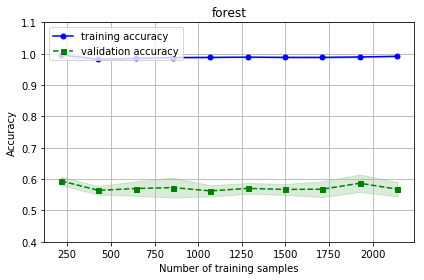

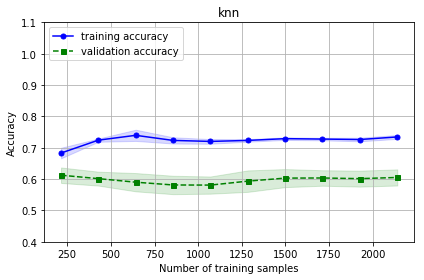

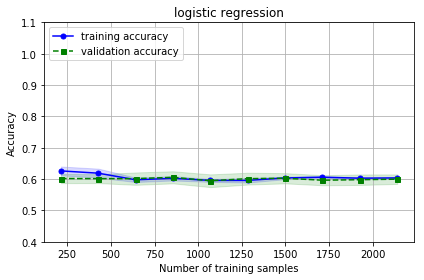

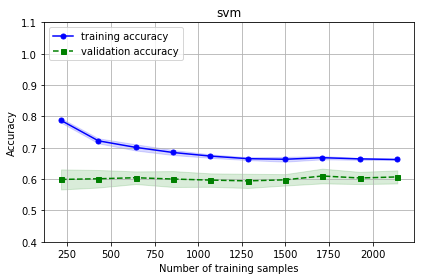

In [17]:
#learning curve
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt




for clf,clfname in zip([forest, knn, lr, svm],['forest','knn','logistic regression','svm']):
    
    if clf == forest:
        pipe = Pipeline([('clf', clf)])
        learning_curve_plot(pipe, X_train, y_train, clfname)
        
    else:
        pipe = Pipeline([('scl', StandardScaler()), ('clf', clf)])
        learning_curve_plot(pipe, X_train, y_train, clfname)

#### According to validation curves, random forest always have high variance no matter how many trees in it, and logistic regression remain low variance with different Cs.

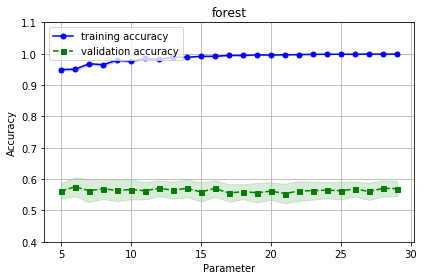

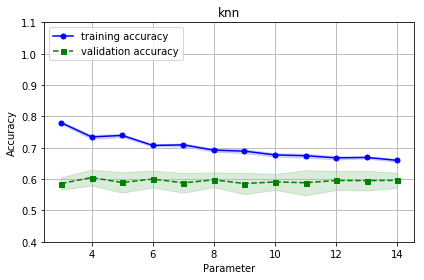

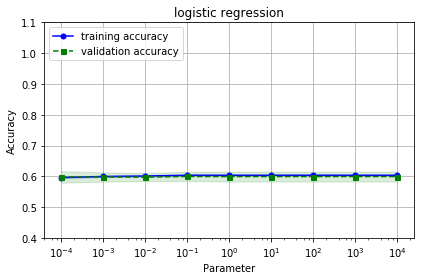

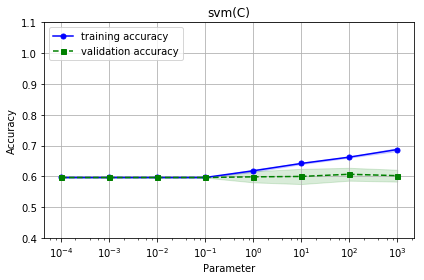

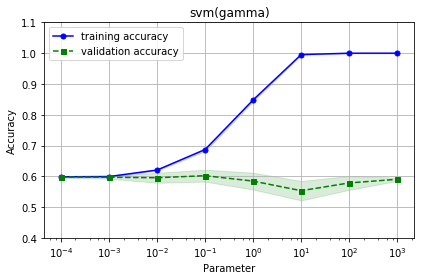

In [18]:
#validation curve
from sklearn.model_selection import validation_curve

forest_param_range = np.arange(5,30)

knn_param_range = np.arange(3,15)

lr_param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]

svm_param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] 
                  
for clf,clfname,param_range, param_name in zip([forest, knn, lr, svm, svm],['forest','knn','logistic regression','svm(C)','svm(gamma)'], 
                                               [forest_param_range, knn_param_range,lr_param_range,svm_param_range, svm_param_range],
                                               ['clf__n_estimators', 'clf__n_neighbors','clf__C', 'clf__C','clf__gamma']):
    if clf != forest:
        pipe = Pipeline([('scl', StandardScaler()), ('clf', clf)])
        
    else:
        pipe = Pipeline([('clf', clf)])
        
    train_scores, test_scores = validation_curve(estimator=pipe,
                                                 X=X_train, 
                                                 y=y_train, 
                                                 param_name=param_name, 
                                                 param_range=param_range,
                                                 cv=10)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(param_range, train_mean, 
             color='blue', marker='o', 
             markersize=5, label='training accuracy')

    plt.fill_between(param_range, train_mean + train_std,
                     train_mean - train_std, alpha=0.15,
                     color='blue')

    plt.plot(param_range, test_mean, 
             color='green', linestyle='--', 
             marker='s', markersize=5, 
             label='validation accuracy')

    plt.fill_between(param_range, 
                     test_mean + test_std,
                     test_mean - test_std, 
                     alpha=0.15, color='green')

    if param_name == 'clf__C'or param_name == 'clf__gamma' :
         plt.xscale('log')
    
    plt.grid()
    plt.title(clfname)
    plt.legend(loc='upper left')
    plt.xlabel('Parameter')
    plt.ylabel('Accuracy')
    plt.ylim([0.4, 1.1])
    plt.tight_layout()
    plt.show()

#### according to confusion matrix, the four algorithms have higher probability to predict a positive move.

In [20]:
from sklearn.metrics import confusion_matrix
for clf,clfname in zip([forest, knn, lr, svm],['forest','knn','logistic regression','svm']):
    
    if clf == forest:
        pipe = Pipeline([('clf', clf)])        
        pipe.fit(X_train, y_train)
        y_pred_pipe = pipe.predict(X_test)
        confmat_pipe = confusion_matrix(y_true=y_test, y_pred=y_pred_pipe)
        
        print('[%s] confusion matrix: \n %r '
              %(clfname, confmat_pipe))
        
    else:
        pipe = Pipeline([('scl', StandardScaler()), ('clf', clf)])
              
        pipe.fit(X_train, y_train)
        y_pred_pipe = pipe.predict(X_test)
        confmat_pipe = confusion_matrix(y_true=y_test, y_pred=y_pred_pipe)
        
        print('[%s] confusion matrix: \n %r '
              %(clfname, confmat_pipe))

[forest] confusion matrix: 
 array([[246,  95],
       [154, 100]]) 
[knn] confusion matrix: 
 array([[289,  52],
       [173,  81]]) 
[logistic regression] confusion matrix: 
 array([[323,  18],
       [225,  29]]) 
[svm] confusion matrix: 
 array([[336,   5],
       [253,   1]]) 
